Copyright 2019 The Google Research Authors.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

     http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

# DVRL for Corrupted Sample Discovery and Robust Learning with Transfer Learning on Image Data

 * Jinsung Yoon, Sercan O Arik, Tomas Pfister, "Data Valuation using Reinforcement Learning", arXiv preprint arXiv:1909.11671 (2019) - https://arxiv.org/abs/1909.11671

This notebook describes the user-guide of corrupted sample discovery and robust learning **with transfer learning on image data** applications using "Data Valuation using Reinforcement Learning (DVRL)". We use Inception-v3 model (pre-trained on Imagenet dataset (http://www.image-net.org/)) as the encoder model to encode image data.

There are some scenarios where training samples may contain corrupted samples, e.g. due to cheap label collection methods. An automated corrupted sample discovery method would be highly beneficial for distinguishing samples with clean vs. noisy labels. Data valuation can be used in this setting by having a small clean validation set to assign low data values to the potential samples with noisy labels. With an optimal data value estimator, all noisy labels would get the lowest data values. 

DVRL can also reliably learn with noisy data in an end-to-end way. Ideally, noisy samples should get low data values as DVRL converges and a high performance model can be returned.

You need:

**Training set** (low-quality data (e.g. noisy data)) / **Validation set** (high-quality data (e.g. clean data)) / **Testing set** (high-quality data (e.g. clean data)) 
 * If there is no explicit validation set, you can split a small portion of testing set as the validation set. 
 * Note that training set does not have to be low quality for DVRL; however, in this notebook, we use a low quality training set for a clearer demonstration as the samples are easier to distinguish in terms of their values.
 * If you have your own training / validation / testing datasets, you can put them under './repo/data_files/' directory with 'train.npz', 'valid.npz', 'test.npz' names.
 * In this notebook, we use CIFAR10 and CIFAR100 datasets (https://www.cs.toronto.edu/~kriz/cifar.html) as examples.

## Prerequisite

Clone https://github.com/google-research/google-research.git to the current directory.

In [1]:
import os
from git import Repo

# Current working directory
repo_dir = os.getcwd() + '/repo'

if not os.path.exists(repo_dir):
    os.makedirs(repo_dir)

# Clones github repository
if not os.listdir(repo_dir):
    git_url = "https://github.com/google-research/google-research.git"
    Repo.clone_from(git_url, repo_dir)

## Necessary packages and functions call

 * data_loading: Data loader for image datasets (cifar10 or cifar100 datasets)
 * keras: Basic packages for defining encoder model and predictor model
 * dvrl: Data valuation model
 * dvrl_metrics: Metrics to evaluate the quality of data valuation

In [1]:
from dvrl import data_loading, dvrl, dvrl_metrics

import keras
from keras import applications, layers, models

# Sets current directory
os.chdir(repo_dir)

import numpy as np
from sklearn import linear_model
import tensorflow as tf

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


## Data loading & Sample corruption

 * Create training, validation and testing sets from the image datasets and save them as train.npz, valid.npz, test.npz under './repo/data_files/ directory.
 * If you have your own train.npz, valid.npz, test.npz, just save them '.repo/data_files/' directory and you can skip this cell.

In [2]:
# Data name: 'cifar10' or 'cifar100' in this notebook
data_name = 'cifar10'

# The number of training, validation and testing samples
dict_no = dict()
dict_no['train'] = 4000
dict_no['valid'] = 1000
dict_no['test'] = 2000

# Label noise ratio
noise_rate = 0.2

# Loads data and corrupts labels
noise_idx = data_loading.load_image_data(data_name, dict_no, noise_rate)
# noise_idx: ground truth noisy label indices

print('Finished data loading.')

Finished data loading.


## Data preprocessing

 * Extract features and labels from train.npz, valid.npz, test.npz in './repo/data_files/' directory

In [3]:
# Extracts features and labels. 
x_train, y_train, x_valid, y_valid, x_test, y_test = \
data_loading.load_image_data_from_file('train.npz', 'valid.npz', 'test.npz')

print('Finished data preprocess.')

Finished data preprocess.


## Encode images

 * Use encoder model (in this notebook, Inception-v3 pre-trained on Imagenet dataset), we encodes the training, validation, and testing images.

In [4]:
# Encodes samples
# The preprocessing function used on the pre-training dataset is also applied while encoding the inputs.
preprocess_function = applications.inception_v3.preprocess_input
input_shape = (299, 299)

# Defines the encoder model to learn the representations for image dataset. In this example, we are considering the InceptionV3 model trained on
# ImageNet dataset, followed by simple average pooling-based downsampling.

def encoder_model(architecture='inception_v3', pre_trained_dataset='imagenet', downsample_factor=8):
    """Returns encoder model.

    Args:
      architecture: Base architecture of encoder model (e.g. 'inception_v3')
      pre_trained_dataset: The dataset used to pre-train the encoder model
      downsample_factor: Downsample factor for the outputs
    """
    tf_input = layers.Input(shape=(input_shape[0], input_shape[1], 3))
    if architecture == 'inception_v3':
        model = applications.inception_v3.InceptionV3(
            input_tensor=tf_input, weights=pre_trained_dataset, include_top=False)
        output_pooled = layers.AveragePooling2D((downsample_factor, downsample_factor),
                                                strides=(downsample_factor, downsample_factor))(model.output)
    return models.Model(model.input, output_pooled)

# Encodes training samples
enc_x_train = data_loading.encode_image(x_train, encoder_model, input_shape, preprocess_function)
# Encodes validation samples
enc_x_valid = data_loading.encode_image(x_valid, encoder_model, input_shape, preprocess_function)
# Encodes testing samples
enc_x_test = data_loading.encode_image(x_test, encoder_model, input_shape, preprocess_function)

print('Finished data encoding')

Instructions for updating:
Colocations handled automatically by placer.
250/250 [==============================] - 328s 1s/step


Exception ignored in: <function BaseSession._Callable.__del__ at 0x7fa61201cf28>
Traceback (most recent call last):
  File "/usr/local/google/home/jinsungyoon/anaconda3/lib/python3.7/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/google/home/jinsungyoon/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


125/125 [==============================] - 86s 691ms/step
Finished data encoding


## Run DVRL

1. **Input**: 

 * data valuator network parameters: Set network parameters of data valuator.
 * pred_model: The predictor model that maps output from the input. Any machine learning model (e.g. a neural network or ensemble decision tree) can be used as the predictor model, as long as it has fit, and predict (for regression)/predict_proba (for classification) as its subfunctions. Fit can be implemented using multiple backpropagation iterations.
 
 
2. **Output**:
 * data_valuator: Function that uses training set as inputs to estimate data values
 * dvrl_predictor: Function that predicts labels of the testing samples
 * dve_out: Estimated data values for all training samples

In [5]:
# Resets the graph
tf.reset_default_graph()
keras.backend.clear_session()

# Network parameters
parameters = dict()
parameters['hidden_dim'] = 100
parameters['comb_dim'] = 10
parameters['iterations'] = 1000
parameters['activation'] = tf.nn.relu
parameters['layer_number'] = 5
parameters['batch_size'] = 2000
parameters['learning_rate'] = 0.01
parameters['inner_iterations'] = 100
parameters['batch_size_predictor'] = 256

# Sets checkpoint file name
checkpoint_file_name = './tmp/model.ckpt'

# Defines predictive model
problem = 'classification'

pred_model = keras.models.Sequential()
pred_model.add(keras.layers.Dense(len(set(y_train)), activation='softmax'))
pred_model.compile(optimizer='adam', loss='categorical_crossentropy',
                   metrics=['accuracy'])

# Flags for using stochastic gradient descent / pre-trained model
flags = {'sgd': True, 'pretrain': False}

# Initalizes DVRL
dvrl_class = dvrl.Dvrl(enc_x_train, y_train, enc_x_valid, y_valid, 
                       problem, pred_model, parameters, checkpoint_file_name, flags)

# Trains DVRL
dvrl_class.train_dvrl('accuracy')

print('Finished DVRL training.')

# Estimates data values
dve_out = dvrl_class.data_valuator(enc_x_train, y_train)

# Predicts with DVRL
y_test_hat = dvrl_class.dvrl_predictor(enc_x_test)

print('Finished data valuation.')

Instructions for updating:
Use tf.cast instead.


Exception ignored in: <function BaseSession._Callable.__del__ at 0x7fa61201cf28>
Traceback (most recent call last):
  File "/usr/local/google/home/jinsungyoon/anaconda3/lib/python3.7/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/google/home/jinsungyoon/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



100%|██████████| 1000/1000 [29:39<00:00,  1.73s/it]


Finished dvrl training.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./tmp/model.ckpt
Finished data valuation.


## Evaluations

 * In this notebook, we use Logistic Regression (on top of Inception-v3) as the predictive model in DVRL (but we can also replace it with another method for evaluation purposes.
 * Here, we use average accuracy as the performance metric (we can also replace with other metrics, see metrics.py).

### 1. Robust learning

DVRL learns robustly although the training data contains low quality/noisy samples, using the guidance from the high quality/clean validation data via reinforcement learning.
 * Train predictive model with weighted optimization using estimated data values by DVRL as the weights

In [6]:
# Defines evaluation model
eval_model = linear_model.LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=200)

# Robust learning (DVRL-weighted learning)
robust_perf = dvrl_metrics.learn_with_dvrl(dve_out, eval_model, enc_x_train, y_train, 
                                           enc_x_valid, y_valid, enc_x_test, y_test, 'accuracy')

print('DVRL-weighted learning performance: ' + str(np.round(robust_perf, 4)))

DVRL-weighted learning performance: 0.8325


### 2. Removing high/low valued samples

Removing low value samples from the training dataset can improve the predictor model performance, especially in the cases where the training dataset contains corrupted samples. On the other
hand, removing high value samples, especially if the dataset is small, would decrease the performance significantly. Overall, the performance after removing high/low value samples is a strong
indicator for the quality of data valuation.

DVRL can rank the training data samples according to their estimated data value, and **by removing the low value samples we can improve performance, whereas removing the high value samples degrades the performance**.

 * Train predictive models after removing certain portions of high/low valued training samples
 * Visualize the results using line graphs (set plot = True).
 * x-axis: Portions of removed samples
 * y-axis: Prediction performance (accuracy)
 * Blue line: Removing low value data, Orange line: Removing high value data

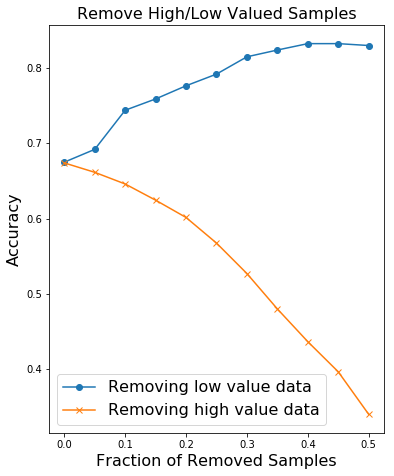

In [7]:
# Evaluates performance after removing high/low values
remove_high_low_performance = \
dvrl_metrics.remove_high_low(dve_out, eval_model, enc_x_train, y_train, 
                             enc_x_valid, y_valid, enc_x_test, y_test, 'accuracy', plot = True)

### 3. Corrupted sample discovery

For our synthetically-generated noisy training dataset, we can assess the performance of our method in finding the noisy samples by using the known noise indices. Note that unlike the first two evaluations, this cell is only for academic purposes because you need the ground truth noisy sample indices so if users come with their own .csv files, they cannot use this cell.

 * Report True Positive Rates (TPR) of corrupted sample discovery.
 * Visualize the results using line graphs (set plot = True).
 * x-axis: Portions of inspected samples.
 * y-axis: True positive rates (TPR) of corrupted sample discovery.
 * Blue line: DVRL, Orange line: Optimal, Green line: Random.

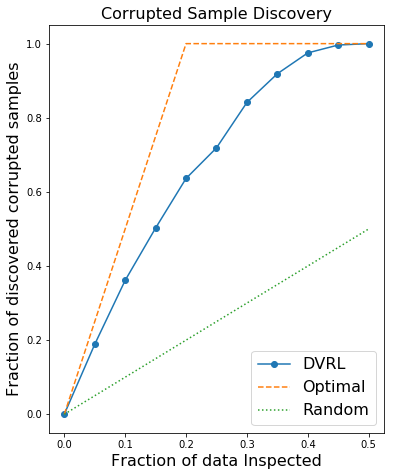

In [8]:
# If noise_rate is positive value.
if noise_rate > 0:
    
    # Evaluates true positive rates (TPR) of corrupted sample discovery and plot TPRs
    noise_discovery_performance = \
    dvrl_metrics.discover_corrupted_sample(dve_out, noise_idx, noise_rate, plot = True)